In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math
import os
from itertools import product
from datetime import datetime
from dateutil.relativedelta import relativedelta
from quant_functions import anal_funcs, data_funcs

import yfinance as yf
## FRED 정보 수집
from fredapi import Fred

In [2]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
## ns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

##### Data load

In [3]:
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [4]:
ticker_dict = {'SPY':'S&P500', 'QQQ':'Nasdaq100', 'IWM':'Russell2000',
               'VTI':'Total_US_Stock_Market', 'VT':'Total_World_Stock_Market', 'VEA':'Developed_Markets_ex_US', 'VWO':'Emerging_Markets',
               'SHV':'Super_Short_Term_Treasury', 'SHY':'Short_Term_Treasury', 'IEF':'Intermediate_Term_Treasury', 'TLT':'Long_Term_Treasury', 'TIP':'TIPS', 'BND':'Total_Bond_Market',
               'VNQ':'Real_Estate', 'RWX':'Global_Real_Estate',
               'GLD':'Gold', 'DBC':'Commodities', 'USO':'Oil', 'GSG':'Energy'}

In [5]:
dataset = data_funcs.get_merged_df('SPY', 'QQQ', 'IWM', 'VTI', 'VT', 'VEA', 'VWO', 'SHV', 'SHY','IEF', 'TLT', 'TIP', 'BND', 'VNQ', 'RWX', 'GLD', 'DBC', 'USO', 'GSG')
dataset = dataset[['SPY', 'QQQ', 'IWM', 'VTI', 'VT', 'VEA', 'VWO', 'SHV', 'SHY','IEF', 'TLT', 'TIP', 'BND', 'VNQ', 'RWX', 'GLD', 'DBC', 'USO', 'GSG']]

[*********************100%%**********************]  19 of 19 completed


In [6]:
## 무위험자산
dataset['CASH'] = range(len(dataset))
dataset['CASH'] = dataset['CASH'].apply(lambda x:((1.025)**1/252+1)**x)

In [7]:
## 
datasemi = dataset[['SPY', 'QQQ', 'SHY','IEF', 'TLT', 'GLD', 'CASH']].copy()

##### 상관계수

In [8]:
## corrset = dataset.rename(columns=ticker_dict).pct_change().corr()
## corrsemi = datasemi.rename(columns=ticker_dict).pct_change().corr()

corrset = dataset.pct_change().corr()
corrsemi = datasemi.pct_change().corr()

In [9]:
# # 히트맵 시각화
# plt.figure(figsize=(12, 8))

# custom_colors = ["#F7FBFF", "#6BAED6", "#08306B"]
# custom_cmap = LinearSegmentedColormap.from_list("custom_blue", custom_colors)

# sns.heatmap(corrsemi, annot=True, cmap=custom_cmap, fmt='.2f',
#             linewidths=0.5, cbar_kws={"shrink": .8}, cbar=False, annot_kws={"size": 12})
# plt.title('Asset Correlations', fontsize=22, fontweight="bold", color="#333333")
# plt.ylabel("Ticker", fontsize=16, labelpad=-45, fontweight="bold", color="#6E6E6E", loc="top", rotation=0)
# plt.xlabel("")
# plt.yticks(rotation=0, fontsize=12)
# plt.xticks(rotation=0, fontsize=12)
# plt.tight_layout()
# plt.show()

##### 조합별 수익률

###### QQQ + TLT

In [10]:
df = dataset[['QQQ', 'TLT']].dropna()
df = df/df.iloc[0]

In [11]:
# df.plot()
# plt.yscale('log')

In [12]:
def simulate_portfolio_assets(asset_rets_df, weights_list, initial_investment=100):
    """
    n개의 자산에 대한 투자 비중에 따른 포트폴리오 시뮬레이션.

    Parameters:
        asset_returns (list of pd.Series): 각 자산의 수익률 시계열 데이터프레임.
        weights_list (list of list): 자산별 비중 리스트. 각 리스트의 합은 1이어야 함.
        initial_investment (float): 초기 투자 금액 (기본값: 100).

    Returns:
        pd.DataFrame: 각 비중 조합에 대한 포트폴리오 가치 시계열 데이터프레임.
    """
    asset_rets_list = [asset_rets_df[col] for col in asset_rets_df.columns]
    portfolio_values = {}
    for weights in weights_list:
        _weights = [i/sum(weights) for i in weights]
        # 포트폴리오 수익률 계산 (각 자산의 비중 곱)
        portfolio_returns = sum(w * r for w, r in zip(_weights, asset_rets_list))
        # 초기 투자 금액 기준 포트폴리오 가치 시계열 계산
        portfolio_cum_value = initial_investment * (1 + portfolio_returns).cumprod()
        portfolio_values[str(weights)] = portfolio_cum_value

    # 데이터프레임으로 변환
    portfolio_df = pd.DataFrame(portfolio_values)
    return portfolio_df

In [13]:
rets = df.pct_change().fillna(0)

In [14]:
result_df = simulate_portfolio_assets(rets, [(10,0), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (0,10)])
result_df.columns = ['QQQ', '9:1', '8:2', '7:3', '6:4', '5:5', '4:6', '3:7', '2:8', '1:9', 'TLT']

In [15]:
# temp.plot()
# plt.yscale('log')

In [16]:
## sortino ratio
sort_df = anal_funcs.get_Vol_report(result_df, 'g', unit='daily', rf=0)

In [17]:
# # 색상 및 크기 설정
# colors = ["#E63946", "#4361EE", "#4361EE", "#4361EE", "#4361EE", "#4361EE", "#4361EE", "#4361EE", "#4361EE", "#4361EE", "#7209B7"]
# sizes = 500

# # 그래프 설정
# fig, ax = plt.subplots(figsize=(12, 8))

# # 점 그리기
# x = sort_df['Volatility']
# y = sort_df['Return']
# scatter = ax.scatter(x, y, c=colors, s=sizes, edgecolors="white", linewidth=2, alpha=0.9)


# # 데이터 레이블 추가
# labels = list(sort_df.index)
# for i, label in enumerate(labels):
#     plt.text(
#         x[i], y[i]-0.2, label, fontsize=12, ha="center", va="center", 
#         color="white", fontweight="bold", bbox=dict(facecolor=colors[i], edgecolor='none', alpha=0.8, boxstyle="round,pad=0.3")
#     )

# # % 단위를 추가하는 포맷터 함수 정의
# def percent_formatter(x, pos):
#     return f"{int(x)}%"

# # X축, Y축에 % 포맷터 적용
# plt.gca().xaxis.set_major_formatter(FuncFormatter(percent_formatter))
# plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))
# # 눈금과 축 간격 줄이기
# plt.gca().tick_params(axis="x", pad=1)  # X축 눈금 패딩 조정
# plt.gca().tick_params(axis="y", pad=1)  # Y축 눈금 패딩 조정

# # 축 설정
# plt.title("Return-Risk Profile : 2002~2024", fontsize=22, fontweight="bold", color="#333333")
# plt.xlabel("Risk", fontsize=16, labelpad=-10, fontweight="bold", color="#6E6E6E", loc="right")
# plt.ylabel("Return", fontsize=16, labelpad=-50, fontweight="bold", color="#6E6E6E", loc="top", rotation=0)
# plt.xticks(fontsize=10, color="#6E6E6E")
# plt.yticks(fontsize=10, color="#6E6E6E")
# plt.xlim(2.9, 5.7)
# plt.ylim(2.4, 6.9)
# plt.grid(color="#E0E0E0", linestyle="--", linewidth=0.7, alpha=0.7)

# # 저장 및 출력
# plt.tight_layout()
# plt.show()


In [18]:
## 전고점대비 최대낙폭(MDD)
MDD, HRR = anal_funcs.get_MDD_report(result_df, 'a')

In [19]:
# HRR[['(10, 0)', '(5, 5)', '(0, 1)']].plot()

##### 분할탐색

In [20]:
def split_time_series(df, n_days):
    split_days = n_days
    dfs = []
    for i in range(len(df)-split_days+1):
        dfs.append(df[i:split_days+i])
    return dfs

In [21]:
rets = df.pct_change().fillna(0)

In [22]:
df_ls = split_time_series(df, 5*252)

In [23]:
i = 0

In [40]:
_df = df_ls[i].copy()
_df['5:5'] = simulate_portfolio_assets(_df.pct_change().fillna(0), [(5,5)])['(5, 5)']
temp = anal_funcs.get_Vol_report(_df, 'g', unit='daily', rf=0)[['Return', 'Volatility', 'Volatility(Down)']]

In [44]:
## TODO
col1_ls = []
col2_ls = []
col3_ls = []
for i in range(len(df_ls)):
    _df = df_ls[i].copy()
    _df['5:5'] = simulate_portfolio_assets(_df.pct_change().fillna(0), [(5,5)])['(5, 5)']
    temp = anal_funcs.get_Vol_report(_df, 'g', unit='daily', rf=0)[['Return', 'Volatility', 'Volatility(Down)']]
    
    col1 = pd.DataFrame(temp.iloc[0, :]).T
    col1.index = [_df.index[0]]
    col1_ls.append(col1)
    
    col2 = pd.DataFrame(temp.iloc[1, :]).T
    col2.index = [_df.index[0]]
    col2_ls.append(col2)
    
    col3 = pd.DataFrame(temp.iloc[2, :]).T
    col3.index = [_df.index[0]]
    col3_ls.append(col3)

In [49]:
col1_df = pd.concat(col1_ls)
col2_df = pd.concat(col2_ls)
col3_df = pd.concat(col3_ls)

<Axes: >

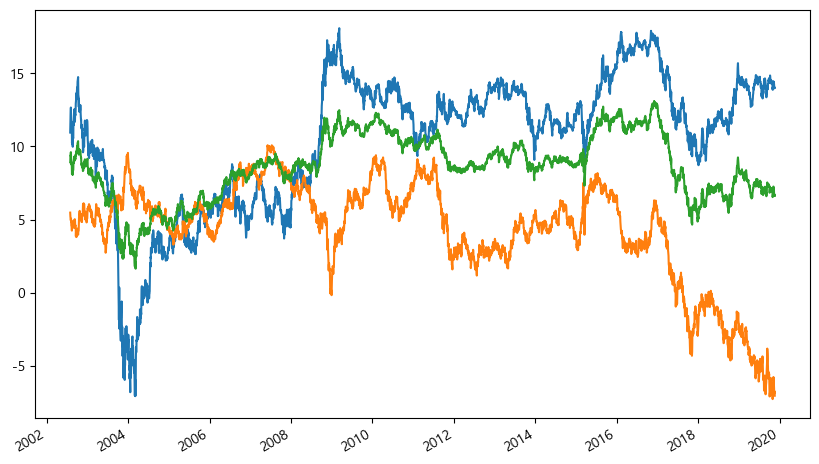

In [50]:
col1_df['Return'].plot()
col2_df['Return'].plot()
col3_df['Return'].plot()